In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
import pickle
import itertools

from utils import *
from scipy.signal import savgol_filter

folder_path = 'dir_sweep_all_2'
# folder_path = 'dir_sweep_hires'

# List all files in the folder
files = os.listdir(folder_path)

# Create a dictionary to store the dataframes
ntrt_dataframes = {}

# Loop through the files and read them into dataframes
for file in files:
    file_path           = os.path.join(folder_path, file)
    df_name             = file.split('.')[0]
    ntrt_dataframes[df_name] = pd.read_csv(file_path, skiprows=1)

# Display the names of the dataframes
ntrt_dataframes.keys()

dict_keys(['_12132024_140802', '_12132024_140816', '_12132024_140619', '_12132024_143304', '_12132024_141513', '_12132024_145013', '_12132024_140143', '_12132024_142754', '_12132024_140631', '_12132024_142026', '_12132024_144457', '_12132024_144331', '_12132024_142740', '_12132024_141249', '_12132024_140157', '_12132024_143853', '_12132024_145205', '_12132024_141711', '_12132024_143106', '_12132024_141739', '_12132024_145239', '_12132024_143648', '_12132024_144127', '_12132024_140355', '_12132024_142224', '_12132024_140433', '_12132024_143933', '_12132024_141842', '_12132024_144709', '_12132024_140209', '_12132024_143700', '_12132024_143714', '_12132024_141103', '_12132024_140553', '_12132024_143728', '_12132024_142350', '_12132024_144721', '_12132024_141659', '_12132024_142813', '_12132024_143502', '_12132024_141315', '_12132024_141301', '_12132024_143516', '_12132024_141329', '_12132024_144251', '_12132024_140751', '_12132024_144522', '_12132024_140744', '_12132024_144244', '_1213202

No ground contact found for _12132024_145317 within the specified conditions.
No ground contact found for _12132024_144818 within the specified conditions.
No ground contact found for _12132024_145320 within the specified conditions.
No ground contact found for _12132024_144821 within the specified conditions.
No ground contact found for _12132024_145346 within the specified conditions.


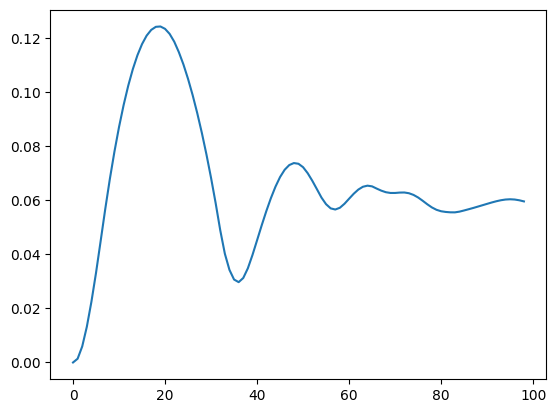

In [3]:
# Consider only results between release_time and end_time to ignore settling motion before jump and tumbling motion after landing
release_time        = 3.0
end_time            = 5.0
sim_time            = ntrt_dataframes[list(ntrt_dataframes.keys())[0]]['time']
closest_start_index = (sim_time - release_time).abs().idxmin()
closest_end_index   = (sim_time - end_time).abs().idxmin()

# Compute centroid to estimate CoM position
avg_pos_dataframes = {}
for name, df in ntrt_dataframes.items():
    avg_pos_dataframes[name] = extract_position_data(df)
    avg_pos_dataframes[name] = avg_pos_dataframes[name].iloc[closest_start_index:closest_end_index].reset_index(drop=True)

# Centre trajectory start on origin
for name, df in avg_pos_dataframes.items():
    avg_pos_dataframes[name] = df - df.iloc[0]

######
# This is my attempt to truncate trajectories so that only the section BEFORE the first ground impact is
# considered. It works ~ok~
######

rise_time    = 20
ground_level = 0.2

trunc_avg_traj = {}
for name, df in avg_pos_dataframes.items():
    ground_contact_df = df[(df.index > rise_time) & (df['avg_y'] < ground_level)]
    if not ground_contact_df.empty:
        ground_contact_index = ground_contact_df.index[0]
        # print(f"First ground contact for {name} is at index {ground_contact_index}")
        trunc_avg_traj[name] = df.iloc[:ground_contact_index]
    else:
        print(f"No ground contact found for {name} within the specified conditions.")

plt.plot(avg_pos_dataframes['_12132024_140802']['avg_y'])

# def derivate_sign_change(values):
#     # Calculate the derivative
#     derivative = np.diff(values)
    
#     # Find indices where the sign of the derivative changes
#     sign_change_indices = np.where(np.diff(np.sign(derivative)))[0] + 1
    
#     return sign_change_indices.tolist()

# impact_margin = 4

# trunc_avg_traj = {}
# for name, df in avg_pos_dataframes.items():
#     dy_sign_changes = derivate_sign_change(df['avg_y'])
#     if len(dy_sign_changes) <2:
#         trunc_avg_traj[name] = df.iloc[:-impact_margin]
#     else:
#         trunc_avg_traj[name] = df.iloc[:(dy_sign_changes[1] - impact_margin)]

In [4]:
# Visualise 3D trajectories to see how well the truncation worked.
# Looks like it's a bit too conservative on the smaller ones but works ok on the bigger ones

fig = go.Figure()

for df in trunc_avg_traj:
    name = df
    df = trunc_avg_traj[df]
    fig.add_trace(go.Scatter3d(x=df['avg_x'], y=df['avg_z'], z=df['avg_y'], mode='lines', name=name))

fig.update_layout(scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                  title='3D Plot of Average Positions')

fig.show()

fig.write_html("dir_sweep_plot.html")

In [5]:
# # Load the sheets "46comp" and "50dir" from the Excel file into DataFrames
# file_path = "stb_vert_trajectories.xlsx"
# df_dir   = pd.read_excel(file_path, sheet_name="50dir")

# # Ensure trajectories all start at the same point
# for col in df_dir.columns:
#     if col.startswith('x'):
#         df_dir[col] -= df_dir[col].iloc[0]

# dir_avg  = create_averaged_trajectory(df_dir)

# dir_avg.head()

In [6]:
# plt.plot(dir_avg['x_avg'], dir_avg['y_avg'])
# dir_length = -(dir_avg['x_avg'].iloc[-1] - dir_avg['x_avg'].iloc[0])
# print(dir_length)

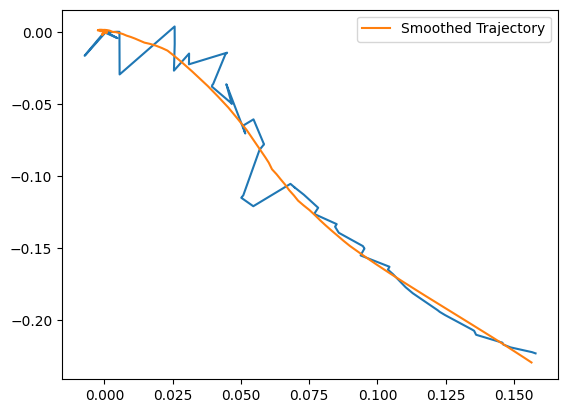

In [7]:

# Load the pickle file
with open('dir_plot_points_2.pkl', 'rb') as file:
    dir_plot_points = pickle.load(file)

xz_dir_points = [(point[0], point[1]) for point in dir_plot_points]

plt.plot([point[0] for point in xz_dir_points], [point[1] for point in xz_dir_points])

# Extract x and z coordinates from xz_dir_points
x_coords = [point[0] for point in xz_dir_points]
z_coords = [point[1] for point in xz_dir_points]

# Apply Savitzky-Golay filter to smooth the coordinates
x_smooth = savgol_filter(x_coords, window_length=51, polyorder=3)
z_smooth = savgol_filter(z_coords, window_length=51, polyorder=3)

# Plot the smoothed trajectory
plt.plot(x_smooth, z_smooth, label='Smoothed Trajectory')
plt.legend()
plt.show()

In [25]:
with open("smoothed_jumps.pkl", "rb") as file:
    xz_dir_smoothed = pickle.load(file)

truncation = 10 # no. frames
rotation   = -2.5 # deg

xz_dir_smoothed = {name: df.truncate(0, 10) for name, df in xz_dir_smoothed.items()}

# Convert rotation from degrees to radians
rotation_rad = np.radians(rotation)

# Create the rotation matrix
rotation_matrix = np.array([[np.cos(rotation_rad), -np.sin(rotation_rad)],
                            [np.sin(rotation_rad), np.cos(rotation_rad)]])

# Rotate each trajectory
for name, df in xz_dir_smoothed.items():
    rotated_coords = np.dot(rotation_matrix, df[['x_smooth', 'y_smooth']].T).T
    xz_dir_smoothed[name] = pd.DataFrame(rotated_coords, columns=['x_smooth', 'y_smooth'])

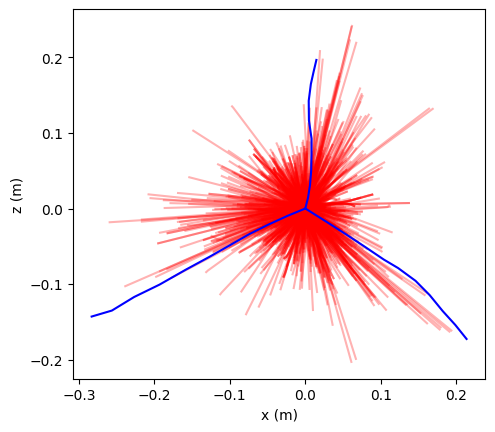

In [29]:
xz_proj_traj = {name: df.drop(columns=['avg_y']) for name, df in trunc_avg_traj.items()}

fig, ax = plt.subplots()

# Set the color cycle before plotting
ax.set_aspect('equal', adjustable='box')
ax.set_prop_cycle('color', ['red'])

actuator_range  = np.linspace(0.0, -0.5, 11)
colours         = itertools.product(actuator_range, actuator_range, actuator_range)
colours         = [(-2*r, -2*g, -2*b) for r, g, b in colours]

# Plot the first trajectory with a label
first = True
count = 0
for name, df in xz_proj_traj.items():
    if first:
        ax.plot(df['avg_x'], df['avg_z'], label='Simulated', alpha=0.3)
        first = False
    else:
        ax.plot(df['avg_x'], df['avg_z'], alpha=0.3)
   

rot_angle_rad   = np.radians(15)
rotation_matrix = np.array([[np.cos(rot_angle_rad), -np.sin(rot_angle_rad)],
                            [np.sin(rot_angle_rad), np.cos(rot_angle_rad)]])
rotated_xz_smooth = np.dot(rotation_matrix, np.array([x_smooth, z_smooth]))

# Add the blue line for xz_dir_points
# ax.plot(rotated_xz_smooth[0], rotated_xz_smooth[1], color='blue', label='Measured')

for key, df in xz_dir_smoothed.items():
        x_columns = [col for col in df.columns if col.startswith('x')]
        y_columns = [col for col in df.columns if col.startswith('y')]
        
        for x_col, y_col in zip(x_columns, y_columns):
            plt.plot(df[x_col], df[y_col], label=f'{key}' if x_col == x_columns[0] else None, color="blue")

ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
# ax.set_title('Projection of Directional Jump Trajectories onto the xz-plane')
# ax.legend()

plt.show()

fig.savefig("xz_projection_trajectories_full.svg", format='svg')
